In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score

from tqdm.auto import tqdm
# import scipy.sparse    # 稀疏矩阵的处理
# import pickle


# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
import os
os.getcwd()

'D:\\Jupyter_code\\Competition\\xunfei_datawhale_DM\\1_车辆贷款违约预测挑战赛'

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample_submit = pd.read_csv('input/sample_submit.csv')

In [4]:
# train['main_active_loan_ratio'] = train['main_account_active_loan_no']/train['main_account_loan_no']
# # train['main_active_loan_ratio'] = train['main_active_loan_ratio'].fillna(0)

# train['active_overdue_loan_ratio'] = train['main_account_active_loan_no']/train['main_account_loan_no']
# # train['active_overdue_loan_ratio'] = train['main_active_loan_ratio'].fillna(0)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    150000 non-null  int64  
 1   main_account_loan_no           150000 non-null  int64  
 2   main_account_active_loan_no    150000 non-null  int64  
 3   main_account_overdue_no        150000 non-null  int64  
 4   main_account_outstanding_loan  150000 non-null  int64  
 5   main_account_sanction_loan     150000 non-null  int64  
 6   main_account_disbursed_loan    150000 non-null  int64  
 7   sub_account_loan_no            150000 non-null  int64  
 8   sub_account_active_loan_no     150000 non-null  int64  
 9   sub_account_overdue_no         150000 non-null  int64  
 10  sub_account_outstanding_loan   150000 non-null  int64  
 11  sub_account_sanction_loan      150000 non-null  int64  
 12  sub_account_disbursed_loan    

In [6]:
train.head()

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.50,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.33,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.00,1991,2019,13,1,28,0
3,54688,43,13,6,1867106,2484678,2486856,0,0,0,...,0,0,1.00,1.42,1964,2019,3,1,55,0
4,63894,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1995,2019,-1,0,24,0


In [7]:
# all_cols = [f for f in train.columns if f not in ['customer_id','loan_default']]

In [8]:
# x_train = train[all_cols]
# x_test = test[all_cols]
# y_train = train['loan_default']

## Train

In [9]:
X = train.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','loan_default'],axis=1)
y = train['loan_default']
X_test = test.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1)

In [10]:
# def cv_model(clf, train_x, train_y, test_x, clf_name):
#     folds = 5
#     seed = 2020
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

#     train = np.zeros(train_x.shape[0])
#     test = np.zeros(test_x.shape[0])

#     cv_scores = []

#     for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
#         print('************************************ {} ************************************'.format(str(i+1)))
#         trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

#         if clf_name == "lgb":
#             train_matrix = clf.Dataset(trn_x, label=trn_y)
#             valid_matrix = clf.Dataset(val_x, label=val_y)

#             params = {
#                 'boosting_type': 'gbdt',
#                 'objective': 'binary',
#                 'metric': 'auc',
#                 'min_child_weight': 5,
#                 'num_leaves': 2 ** 5,
#                 'lambda_l2': 10,
#                 'feature_fraction': 0.8,
#                 'bagging_fraction': 0.8,
#                 'bagging_freq': 4,
#                 'learning_rate': 0.1,
#                 'seed': 2020,
#                 'nthread': 28,
#                 'n_jobs':24,
#                 'silent': True,
#                 'verbose': -1,
#             }

#             model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
#             val_pred = model.predict(val_x, num_iteration=model.best_iteration)
#             test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
#             # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
#         if clf_name == "xgb":
#             train_matrix = clf.DMatrix(trn_x , label=trn_y)
#             valid_matrix = clf.DMatrix(val_x , label=val_y)
            
#             params = {'booster': 'gbtree',
#                       'objective': 'binary:logistic',
#                       'eval_metric': 'auc',
#                       'gamma': 1,
#                       'min_child_weight': 1.5,
#                       'max_depth': 5,
#                       'lambda': 10,
#                       'subsample': 0.7,
#                       'colsample_bytree': 0.7,
#                       'colsample_bylevel': 0.7,
#                       'eta': 0.04,
#                       'tree_method': 'exact',
#                       'seed': 2020,
#                       'nthread': 36,
#                       "silent": True,
#                       }
            
#             watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
#             model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
#             val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
#             test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
#         if clf_name == "cat":
#             params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
#                       'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
#             model = clf(iterations=20000, **params)
#             model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
#                       cat_features=[], use_best_model=True, verbose=500)
            
#             val_pred  = model.predict(val_x)
#             test_pred = model.predict(test_x)
            
#         train[valid_index] = val_pred
#         test = test_pred / kf.n_splits
#         cv_scores.append(roc_auc_score(val_y, val_pred))
        
#         print(cv_scores)
        
#     print("%s_scotrainre_list:" % clf_name, cv_scores)
#     print("%s_score_mean:" % clf_name, np.mean(cv_scores))
#     print("%s_score_std:" % clf_name, np.std(cv_scores))
#     return train, test

# def xgb_model(x_train, y_train, x_test):
#     xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
#     return xgb_train, xgb_test


# lgb_train, lgb_test = xgb_model(X, y, X_test)


In [11]:
xgb.__version__

'1.3.3'

In [12]:
def prob_to_label(x,threshold):
    labels = x.copy()
    labels[labels<threshold]=0
    labels[labels>=threshold]=1
    return labels

# (440000 + 165000*(1 - np.exp((-0.3) * x / 6)))

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def f1_score_custom(y_true, y_pred):
    y_pred = y_pred.round()
    return 'f1', f1_score(y_true, y_pred,average='macro'), True

def floss(prediction, target, beta=1, log_like=False):
    EPS = 1e-10
    # print(prediction)
    N = prediction.size
    TP = (prediction * target).sum()
#     TP = np.logical_and(prediction,target).sum()
    H = beta * target.sum() + prediction.sum()
    fmeasure = (1 + beta) * TP / (H + EPS)
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_  = (1 - fmeasure)
    return floss_

def floss_macro(prediction, target, beta=1, log_like=False):
    EPS = 1e-10
    prediction_inv = np.logical_not(prediction)
    target_inv = np.logical_not(target)
    
    TP_0 = (prediction_inv * target_inv).sum()
    H_0 = beta * target_inv.sum() + prediction_inv.sum()
    fmeasure_0 = (1 + beta) * TP_0 / (H_0 + EPS)
    
    TP_1 = (prediction * target).sum()
    H_1 = beta * target.sum() + prediction.sum()
    fmeasure_1 = (1 + beta) * TP_1 / (H_1 + EPS)
    
    fmeasure = (fmeasure_0+fmeasure_1)/2
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_  = - fmeasure
    return floss_

def floss_macro_2(prediction, target):
    return -f1_score(target,prediction,average='macro')
    


def feval_floss(preds, lgbm_train,threshold):
    labels = lgbm_train.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    return 'floss', round(floss(target = labels, prediction = preds),5), False

def feval_floss_macro(preds, lgbm_train):
    labels = lgbm_train.get_label()
#     print('labels_sum: ',labels.sum())
#     print(preds)
    preds = prob_to_label(preds,threshold=threshold)
#     print('pred_sum: ',preds.sum())
#     print(round(floss_macro(target = labels, prediction = preds),5))
    return 'floss_macro', round(floss_macro(target = labels, prediction = preds),5), False

def feval_floss_macro_xgb(preds, train_matrix):
    labels = train_matrix.get_label()
#     print('labels_sum: ',labels.sum())
    print(preds)
    preds = prob_to_label(preds,threshold=threshold)
#     print('pred_sum: ',preds.sum())
#     print(round(floss_macro(target = labels, prediction = preds),5))
    return 'floss_macro', round(floss_macro(target = labels, prediction = preds),5)

# def evalmcc(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'MCC', matthews_corrcoef(labels, preds > THRESHOLD)


def feval_floss_macro_2(preds, lgbm_train):
    labels = lgbm_train.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    return 'floss_macro_sk', round(floss_macro_2(target = labels, prediction = preds),5), False


In [13]:
base_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric':'None', # (lambda y_true, y_pred: f1_score_custom(y_true, y_pred)),
            'min_child_weight': 5,
            'num_leaves': 2 ** 7,
            'early_stopping_rounds':200,
            'lambda_l2': 10,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 4,
            'learning_rate': 0.01,
            'seed': 2021,
            'n_jobs':-1,
            'verbose': -1,
        }

lgbm_params = {
            # Key Parameters
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt', # 'dart'
            'learning_rate': 0.01,
#             'num_iterations':100  # default=100
            'early_stopping_rounds':200,    
#             'min_child_weight': 5, #叶子上的最小样本数
#             'max_depth': default=-1
#             'num_leaves': 2 ** 7,  # default = 31(2**5-1)
            'num_threads': -1, # 'n_jobs'
                
            # Learning Control Parameters
#             'lambda_l1':
            'lambda_l2': 10,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 4,
    
            'verbose': -1,
            'seed': 2021,
        }

xgb_params={'booster': 'gbtree',
            'objective': 'binary:logistic',
            'eval_metric':'auc',
            'learning_rate': 0.01,
            'max_depth':7, 
            'gamma':1,
            'lambda': 10,
            'eta':0.04, # default=0.3
            'colsample_bytree':0.8, # 生成树时进行的列采样
            'subsample':0.8, # 随机采样训练样本 
#             'binary':'logistic',
            'tree_method':'exact',#
            'nthread':-1,
            'seed':2021
}

cat_params = {'learning_rate': 0.05,
              'depth': 7,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter',
              'eval_metric': feval_floss_macro,
              'od_wait': 50,
              'random_seed': 2021,
              'allow_writing_files': False
}

In [14]:
oof = pd.DataFrame()                 # out-of-fold result
cv_scores = []
cv_scores_2 = []
cv_scores_xgb = []
cv_scores_xgb_2 = []
cv_scores_cat = []
cv_scores_cat_2 = []
f1_list = []
# cv_mean =[]
# cv_std = []
models = []                          # models
scores = 0.0                         # validation score
threshold = 0.25

# thresholds = [0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,
#               0.246,0.247,0.248, 0.249,0.250,0.251,0.252,0.253]

def cv_model(clf, X, y, clf_name):
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        # create dataset
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            lgbm_train = lgbm.Dataset(X_train,y_train)
            lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train)

            # model 
            model = lgbm.train(params=base_params,
                               train_set=lgbm_train,
                               valid_sets=[lgbm_train, lgbm_valid],
                               num_boost_round=5000,
                               feval = feval_floss_macro,
                               verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
            y_pred = prob_to_label(y_pred,threshold)

#             FLOSS = round(floss(target= y_valid, prediction = y_pred),3)
#             print(f'Performance of the　prediction: , floss: {FLOSS}')

        #     cv_scores.append(roc_auc_score(y_valid, y_pred))
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              num_boost_round=50000,
                              evals=watchlist,
#                               feval=feval_floss_macro_xgb,
                              verbose_eval=200,
                              early_stopping_rounds=200)
            
            y_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            y_pred = prob_to_label(y_pred,threshold)
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))
#             pred_labels = prob_to_label(y_pred,i)
#             f1 = f1_score(y_valid,pred_labels,average='macro')
#             f1_list.append(f1)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            y_pred  = model.predict(X_valid)
            y_pred = prob_to_label(y_pred,threshold)
            cv_scores_cat.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_cat_2.append(f1_score(y_valid, y_pred,average='micro'))
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

    print('cv_score: ',cv_scores)    
    print('avg_cv_score: ', np.average(np.array(cv_scores)))


In [15]:
np.average([1,2,3])

2.0

In [16]:
def lgb_model(x_train, y_train):
    lgb_train = cv_model(lgbm, x_train, y_train, "lgb")
    return lgb_train

def xgb_model(x_train, y_train):
    xgb_train = cv_model(xgb, x_train, y_train, "xgb")
    return xgb_train

def cat_model(x_train, y_train):
    cat_train = cv_model(CatBoostRegressor, x_train, y_train,"cat")
    return cat_train

In [17]:
%%time
lgb_train = lgb_model(X, y)
# xgb_train = xgb_model(X, y)
# cat_train = cat_model(X, y)

Fold : 1
Training until validation scores don't improve for 200 rounds
[200]	training's floss_macro: -0.6079	valid_1's floss_macro: -0.56553
[400]	training's floss_macro: -0.64445	valid_1's floss_macro: -0.58196
[600]	training's floss_macro: -0.66444	valid_1's floss_macro: -0.58435


KeyboardInterrupt: 

In [23]:
# %%time
# xgb_train = xgb_model(X, y)

Fold : 1
[0]	train-auc:0.62047	eval-auc:0.61523
[200]	train-auc:0.68244	eval-auc:0.64822
[400]	train-auc:0.70492	eval-auc:0.65777
[600]	train-auc:0.72208	eval-auc:0.66287
[800]	train-auc:0.73465	eval-auc:0.66499
[1000]	train-auc:0.74625	eval-auc:0.66617
[1200]	train-auc:0.75627	eval-auc:0.66673
[1400]	train-auc:0.76598	eval-auc:0.66679
[1427]	train-auc:0.76712	eval-auc:0.66674
****************************************************************************************************
Fold : 2
[0]	train-auc:0.62023	eval-auc:0.61263
[200]	train-auc:0.68173	eval-auc:0.64746
[400]	train-auc:0.70371	eval-auc:0.65682
[600]	train-auc:0.72122	eval-auc:0.66167
[800]	train-auc:0.73363	eval-auc:0.66407
[1000]	train-auc:0.74496	eval-auc:0.66555
[1200]	train-auc:0.75567	eval-auc:0.66649
[1400]	train-auc:0.76525	eval-auc:0.66685
[1600]	train-auc:0.77387	eval-auc:0.66712
[1800]	train-auc:0.78231	eval-auc:0.66721
[2000]	train-auc:0.78988	eval-auc:0.66731
[2200]	train-auc:0.79713	eval-auc:0.66733
[2381]	train-

In [ ]:
f1_score()

## 调参

In [29]:
# 贝叶斯调参
!pip install bayesian-optimization

You should consider upgrading via the 'd:\program\anaconda\python.exe -m pip install --upgrade pip' command.


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11690 sha256=b83b2e8ae3f5223a4aa79f1a5d8d6fe0d8d4210de93ddb42b5ca9808c2d59445
  Stored in directory: c:\users\dingjun\appdata\local\pip\cache\wheels\37\fa\19\f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valia = train_test_split(X, y, test_size=0.2)

In [24]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgbm.LGBMClassifier(boosting_type='gbdt', 
                                   objective='binary', 
                                   metric='auc',
                                   learning_rate=0.1, 
                                   n_estimators=5000,
                                   num_leaves=int(num_leaves), 
                                   max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), 
                                   feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), 
                                   min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, 
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, 
                                   reg_alpha=reg_alpha,
                                   n_jobs= -1
                                  )
    
    cv_score = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='f1_macro').mean()
    
    return cv_score


def rf_cv_xgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgbm.LGBMClassifier(boosting_type='gbdt', 
                                   objective='binary', 
                                   metric='auc',
                                   learning_rate=0.1, 
                                   n_estimators=5000,
                                   num_leaves=int(num_leaves), 
                                   max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), 
                                   feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), 
                                   min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, 
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, 
                                   reg_alpha=reg_alpha,
                                   n_jobs= -1
                                  )
    
    cv_score = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    return cv_score

In [40]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.92, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43
[LightGBM] [Warning] feature_fraction is set=0.92, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.83, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.83
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] bagging_fraction is set=0.62, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62
[LightGBM] [Warning] bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38
[LightGBM] [Warning] feature_fraction is set=0.83, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.83
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] bagging_fraction is set=0.62, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62
[LightGBM] [Warning] bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38
[LightGBM] [Warning] feature_fraction is set=0

[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_fraction is set=0.86, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86
[LightGBM] [Warning] bagging_freq is set=58, subsample_freq=0 will be ignored. Current value: bagging_freq=58
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_fraction is set=0.86, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86
[LightGBM] [Warning] bagging_freq is set=58, subsample_freq=0 will be ignored. Current value: bagging_freq=58
[LightGBM] [Warning] feature_fraction is set=0

[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
|  10       |  0.6553   |  1.0      |  100.0  

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34
|  13       |  0.6594   |  1.0      |  34.67    |  0.5      |  20.0     |  0.0      |  100.0    |  1.0      |  32.78    |  0.0      |  10.0     |
[LightGBM] [Warning] feature_fraction is set=0.97, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.97
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Wa

In [31]:
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1
         ):
    # 这里就不采用交叉验证的cv_score = cross_val_score(model, x, y, scoring="f1", cv=5)
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)
    # f是准备存储预测值的，交叉验证下，用五份数据作为验证集，最后将这五份数据放回f里
    f = np.zeros(X.shape[0])
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X,y)):
        print("fold--{}".format(fold))
        
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        lgbm_train = lgbm.Dataset(X_train,y_train)
        lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train)
        

        params = {'num_leaves': int(num_leaves),
                'min_data_in_leaf': int(min_data_in_leaf), 
                'objective':'binary',
                'max_depth': int(max_depth),
                'learning_rate': 0.01,
                "boosting": "gbdt",
                "feature_fraction": feature_fraction,
                "bagging_fraction": bagging_fraction ,
                "metric": 'auc',
                "lambda_l1": lambda_l1,
                }
        # 因为是交叉验证的算法，这里直接使用train，valid_sets就是要评估的数据集
        model = lgbm.train(params, 
                          lgbm_train, 
                          valid_sets=[lgbm_train, lgbm_valid],
                          num_boost_round=5000, 
                          verbose_eval=200,
                          early_stopping_rounds = 200)
        # 返回迭代中最好的数据,这里的predict里面的数据（不需要经过dataset）不需要再进行转化，如果是xgboost就需要，需要把x_test进行转化DMatrix(x_test),这里x_test不包含类别特征
        f[val_index] = model.predict(X[val_index], num_iteration=model.best_iteration)
        # predict里面的验证集不需要进行dataset，但是xgboost算法时需要dmatrix，并且只需要DMatrix(x_test),这里x_test不包含类别特征,很多地方这里都会出错，直接带着类别就去预测
        del model, trn_idx, val_idx
    # 由于输出的是概率值，转化为0，1的整型值 
    f = np.array([1 if i>0.25 else 0 for i in f])
    return metrics.f1_score(f, y)
    
# 最后进行调参
LGB_CV(
          max_depth=5,
          num_leaves=32,
          min_data_in_leaf=1,
          feature_fraction=0.8,
          bagging_fraction=0.8,
          lambda_l1=None
         )

# 采用贝叶斯优化算法
lgb_ba = BayesianOptimization(LGB_CV, 
        {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10)
        })
lgb_ba.maximize()
lgb_ba.max["params"]

fold--0
[LightGBM] [Info] Number of positive: 21164, number of negative: 98836
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6658
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176367 -> initscore=-1.541160
[LightGBM] [Info] Start training from score -1.541160
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

KeyboardInterrupt: 

In [ ]:

            lgbm_train = lgbm.Dataset(X_train,y_train)
            lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train)

            # model 
            model = lgbm.train(params=base_params,
                               train_set=lgbm_train,
                               valid_sets=[lgbm_train, lgbm_valid],
                               num_boost_round=5000,
                               feval = feval_floss_macro,
                               verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation
            y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
            y_pred = prob_to_label(y_pred,threshold)

#             FLOSS = round(floss(target= y_valid, prediction = y_pred),3)
#             print(f'Performance of the　prediction: , floss: {FLOSS}')

        #     cv_scores.append(roc_auc_score(y_valid, y_pred))
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))

            models.append(model)
            print("*" * 100)

Cross Validation

In [12]:
categorical_feature=['branch_id','supplier_id','manufacturer_id','area_id','employee_code_id',\
                    'mobileno_flag','idcard_flag','Driving_flag','passport_flag',\
                    'Credit_level','employment_type']

In [13]:
%%time
kf = KFold(n_splits=5, random_state=2021, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
cv_scores = []
models = []                          # models
scores = 0.0                         # validation score

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    lgbm_train = lgbm.Dataset(X_train,y_train)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train)
    
    # model 
    model = lgbm.train(params=base_params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      verbose_eval=200,
#                       categorical_feature = ['Driving_flag']        
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_valid, y_pred))
#     cv_scores.append(f1_score(val_y, val_pred,average='macro'))


#     RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
#     print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

#     #keep scores and models
#     scores += RMSPE / 5
    models.append(model)
    print("*" * 100)

Fold : 1
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.710605	valid_1's auc: 0.657079
[400]	training's auc: 0.743375	valid_1's auc: 0.664056
[600]	training's auc: 0.769489	valid_1's auc: 0.666376
[800]	training's auc: 0.790968	valid_1's auc: 0.666099
Early stopping, best iteration is:
[621]	training's auc: 0.772002	valid_1's auc: 0.666507
****************************************************************************************************
Fold : 2
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.710689	valid_1's auc: 0.656881
[400]	training's auc: 0.742973	valid_1's auc: 0.662915
[600]	training's auc: 0.768295	valid_1's auc: 0.66488
[800]	training's auc: 0.789766	valid_1's auc: 0.665391
Early stopping, best iteration is:
[778]	training's auc: 0.787422	valid_1's auc: 0.665463
********************************************

In [14]:
print("%s_scotrainre_list:" % 'lgbm', cv_scores)
print("%s_score_mean:" % 'lgbm', np.mean(cv_scores))
print("%s_score_std:" % 'lgbm', np.std(cv_scores))

lgbm_scotrainre_list: [0.6665074037191319, 0.665462735236708, 0.6653798253532002, 0.6525417062717462, 0.662211448505362]
lgbm_score_mean: 0.6624206238172297
lgbm_score_std: 0.005144897506601224


In [20]:
model = models[0]

Text(0, 0.5, 'Feature')

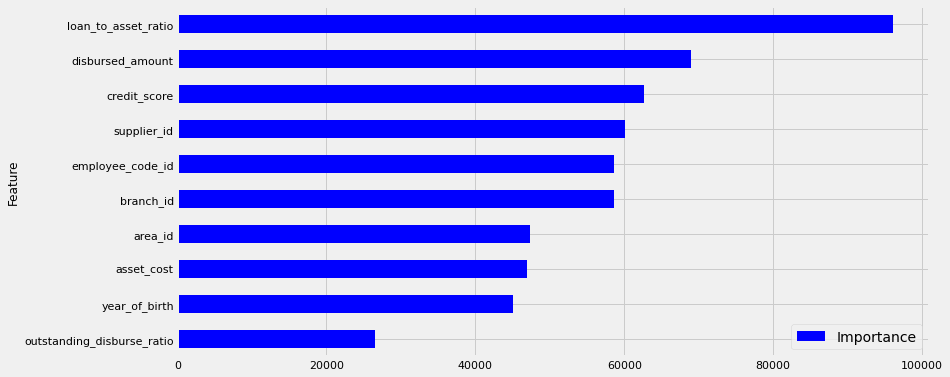

In [32]:
v

## Predict

In [119]:
X_test = test.drop(['customer_id'],axis=1)

In [120]:
target_arr = np.zeros(len(X_test))

In [138]:
for model in tqdm(models,total=len(models)):
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target_arr += pred / len(models)

In [139]:
target = pd.Series(target_arr)
target

0        0.133412
1        0.090725
2        0.217693
3        0.146264
4        0.094359
           ...   
29995    0.253608
29996    0.101897
29997    0.079226
29998    0.202307
29999    0.160320
Length: 30000, dtype: float64

In [140]:
sample_submit

,customer_id,loan_default
0,14342,0
1,94753,0
2,140283,0
3,134742,0
4,4749,0


In [141]:
customer_id_test = test.customer_id
customer_id_test

0         14342
1         94753
2        140283
3        134742
4          4749
          ...  
29995    100643
29996    166843
29997      4084
29998    171136
29999    113851
Name: customer_id, Length: 30000, dtype: int64

In [142]:
customer_id_test.nunique()

30000

In [143]:
target

0        0.133412
1        0.090725
2        0.217693
3        0.146264
4        0.094359
           ...   
29995    0.253608
29996    0.101897
29997    0.079226
29998    0.202307
29999    0.160320
Length: 30000, dtype: float64

In [126]:
concat_features=[customer_id_test,target]

In [149]:
submission = pd.concat(concat_features,axis=1)
submission.rename(columns={0:'loan_default'},inplace = True)
threshold=0.245
submission['loan_default'] = submission['loan_default'].apply(lambda x:1 if x>threshold else 0).values
# submission = pd.DataFrame(data=target,columns=['loan_submit'])
submission

,customer_id,loan_default
0,14342,0
1,94753,0
2,140283,0
3,134742,0
4,4749,0
...,...,...
29995,100643,1
29996,166843,0
29997,4084,0
29998,171136,0


In [150]:
# train['loan_default'].value_counts()
num_of_1 = train.loc[train.loan_default==1,'loan_default'].value_counts()
num_of_1/len(train['loan_default'])
# train.loc[train['loan_default']==1, 'loan_default'].value_counts()

1    0.176967
Name: loan_default, dtype: float64

In [151]:
submission['loan_default'].value_counts()

0    24055
1     5945
Name: loan_default, dtype: int64

In [152]:
num_of_1_test = submission.loc[submission.loan_default==1,'loan_default'].value_counts()
num_of_1_test/len(submission['loan_default'])
# submission['loan_default'].value_counts()

1    0.198167
Name: loan_default, dtype: float64

In [153]:
submission.to_csv('submission_lgbm_728_3.csv',index=0)